# Import

In [75]:
import random
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc, brier_score_loss
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import interp
import lightgbm as lgbm

seed = 42
random.seed(seed)
np.random.seed(seed)

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

rc = {'font.sans-serif': 'SimHei',
      'axes.unicode_minus': False}
sns.set(context='notebook', style='ticks', rc=rc)

import warnings
warnings.filterwarnings("ignore")


# Data


In [118]:
data = pd.read_excel('./data/dataset5.xlsx')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   总体生存时间       393 non-null    float64
 1   生存状态（编码）     393 non-null    int64  
 2   feature_2    393 non-null    int64  
 3   feature_3    393 non-null    int64  
 4   feature_4    393 non-null    int64  
 5   feature_5    393 non-null    int64  
 6   feature_9    393 non-null    int64  
 7   feature_10   393 non-null    float64
 8   feature_11   393 non-null    float64
 9   feature_12   393 non-null    float64
 10  feature_13   393 non-null    float64
 11  feature_14   393 non-null    float64
 12  feature_15   393 non-null    int64  
 13  feature_16   393 non-null    float64
 14  feature_17   393 non-null    float64
 15  feature_18   393 non-null    float64
 16  feature_19   393 non-null    float64
 17  feature_20   393 non-null    int64  
 18  feature_21   393 non-null    int64  
 19  feature_

In [78]:
data.head()

,总体生存时间,生存状态（编码）,feature_2,feature_3,feature_4,feature_5,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_26,feature_27,feature_28,TNM分期（编码汇总）,淋巴清扫
0,6.9079,0,0,1,58,1,1,5.68,51.2,43.1,3.2,42.3,1,19.0,14.9,42.1,11.9,1,2,2,0,3.2,1,0,1,0,1
1,18.5197,0,0,1,48,1,1,12.01,50.4,37.6,2.5,15.0,1,39.0,18.4,40.7,13.0,1,1,2,0,8.0,1,0,0,0,1
2,24.3092,0,0,2,76,0,1,8.99,52.1,37.0,1.7,1.8,0,19.0,14.0,41.9,12.6,1,1,1,0,5.1,1,0,1,0,1
3,9.4408,0,0,1,55,0,1,5.74,55.3,36.8,3.2,3.3,0,18.0,15.3,44.1,11.7,1,2,1,0,8.5,0,1,2,1,0
4,57.1053,1,0,1,51,1,1,9.02,60.3,32.8,3.7,2.1,0,12.0,14.4,41.0,10.9,1,2,2,0,4.7,1,1,1,0,1


In [119]:
# 删除feature21和22
data.drop(["生存状态（编码）", "TNM分期（编码汇总）", "feature_21", "feature_22"], axis=1, inplace=True)
display(data.describe())
display(data.columns)

,总体生存时间,feature_2,feature_3,feature_4,feature_5,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_23,feature_24,feature_26,feature_27,feature_28,淋巴清扫
count,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000
mean,27.1679,0.2646,1.4707,57.5573,0.2774,0.3893,6.5801,7.6089,2.9878,29.3976,10.5374,0.5827,40.7850,29.9694,40.7513,11.8659,1.1120,0.3435,5.3715,0.4580,0.1578,1.3690,0.6921
std,21.8705,0.4417,0.4998,9.8197,0.4483,0.5878,2.1395,13.9802,6.0066,133.3235,34.8370,0.4937,49.4194,58.3024,5.3410,1.5293,0.3157,0.4755,2.8162,0.4989,0.3650,0.5879,0.4622
min,1.5000,0.0000,1.0000,27.0000,0.0000,0.0000,2.2800,1.3200,0.1500,0.6500,0.2000,0.0000,6.0000,3.6000,24.4000,1.1000,1.0000,0.0000,0.7000,0.0000,0.0000,0.0000,0.0000
25%,10.7333,0.0000,1.0000,50.0000,0.0000,0.0000,5.1100,3.1000,1.2100,2.1700,1.5600,0.0000,17.0000,10.5000,37.6000,10.8000,1.0000,0.0000,3.0000,0.0000,0.0000,1.0000,0.0000
50%,22.0000,0.0000,1.0000,59.0000,0.0000,0.0000,6.3000,4.0700,1.5800,3.2000,2.8900,1.0000,25.0000,13.4700,41.2000,11.7000,1.0000,0.0000,5.0000,0.0000,0.0000,1.0000,1.0000
75%,38.0000,1.0000,2.0000,64.0000,1.0000,1.0000,7.6500,5.4600,2.0300,6.4000,5.2400,1.0000,41.0000,19.2000,44.0000,12.7000,1.0000,1.0000,7.0000,1.0000,0.0000,2.0000,1.0000
max,120.0667,1.0000,2.0000,83.0000,1.0000,2.0000,15.3400,87.2000,43.1000,1404.0000,338.0000,1.0000,370.0000,400.3000,78.3000,18.7000,2.0000,1.0000,17.0000,1.0000,1.0000,2.0000,1.0000


Index(['总体生存时间', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
       'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13',
       'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18',
       'feature_19', 'feature_20', 'feature_23', 'feature_24', 'feature_26',
       'feature_27', 'feature_28', '淋巴清扫'],
      dtype='object')

<AxesSubplot: xlabel='feature_14', ylabel='总体生存时间'>

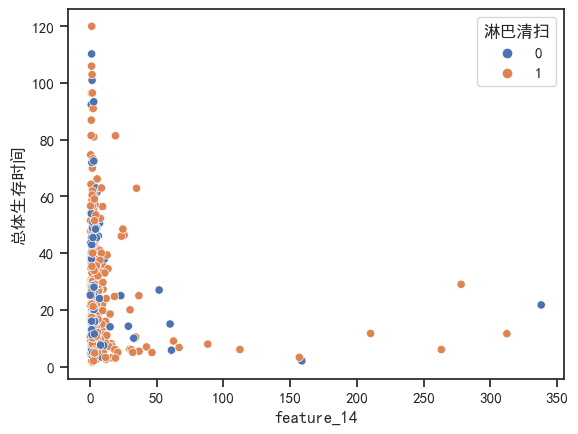

In [80]:
plt.figure()
sns.scatterplot(x=data['feature_14'], y=data['总体生存时间'], hue=data['淋巴清扫'])

# preprocess

## Get class label

In [81]:
def get_class(target):
    if target < 12:
        return 0
    elif target < 24:
        return 1
    elif target < 36:
        return 2
    elif target < 48:
        return 3
    elif target < 60:
        return 4
    else:
        return 5

df = data.copy()
df['总体生存时间'] = df['总体生存时间'].apply(get_class)

Text(0.5, 1.0, 'Number of samples in each class')

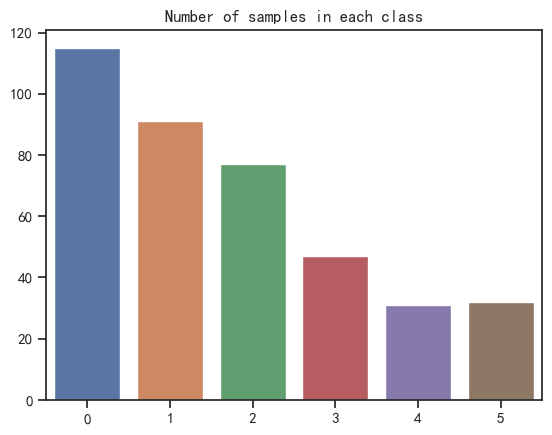

In [82]:
sns.barplot(y=df["总体生存时间"].value_counts().values, x=df["总体生存时间"].value_counts().index)
plt.title("Number of samples in each class")

In [83]:
df.rename(columns={"总体生存时间": "target"}, inplace=True)

with_ = df[df["淋巴清扫"] == 1]
without_ = df[df["淋巴清扫"] == 0]

with_.drop(["淋巴清扫"], axis=1, inplace=True)
without_.drop(["淋巴清扫"], axis=1, inplace=True)

## Split into training set and test set

为保证测试集样本涵盖所有6个类别，使得计算正常，调整训练测试比例

清扫组样本量多，训练集和测试集比例为 **9:1**  
未清扫组样本量较少，训练集和测试集比例为 **8:2**

In [84]:
with_train_x, with_test_x, with_train_y, with_test_y = train_test_split(with_.iloc[:, 1:], with_['target'], test_size=0.1)
without_train_x, without_test_x, without_train_y, without_test_y = train_test_split(without_.iloc[:, 1:], without_['target'], test_size=0.2)

print("LND train size: ", with_train_x.shape)
print("LND test size: ", with_test_x.shape)
print("nLND train size: ", without_train_x.shape)
print("nLND test size: ", without_test_x.shape)

LND train size:  (244, 21)
LND test size:  (28, 21)
nLND train size:  (96, 21)
nLND test size:  (25, 21)


### Nomalization

In [85]:
scaler = StandardScaler()
# scaler = MinMaxScaler()

def normalize(scaler, x, y):
    x = scaler.fit_transform(x)
    y = np.array(y)
    
    return x, y

with_train_x, with_train_y = normalize(scaler, with_train_x, with_train_y)
with_test_x, with_test_y = normalize(scaler, with_test_x, with_test_y)
without_train_x, without_train_y = normalize(scaler, without_train_x, without_train_y)
without_test_x, without_test_y = normalize(scaler, without_test_x, without_test_y)

In [86]:
# 查看清扫组和未清扫组的测试集是否包含所有类别，否则无法成功计算评估指标
print(f'清扫组测试集类别：{with_test_y}\n未清扫组测试集类别：{without_test_y}')

清扫组测试集类别：[2 3 0 3 1 3 0 1 2 1 4 0 0 1 2 0 0 2 3 5 0 0 0 2 3 1 0 4]
未清扫组测试集类别：[2 2 2 0 2 2 2 0 1 0 4 2 3 4 0 2 3 5 3 0 3 2 0 0 0]


# Model

In [87]:
def clf_model_eval(name, model, x, y, test_x, test_y, TNM=True):
    K = 16
    kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
    kf.get_n_splits(x)
    train_acc = []
    train_precision = []
    train_recall = []
    train_f1 = []
    train_auc = []

    # 多折交叉验证
    for train_idx, valid_idx in kf.split(x, y):
        train_x, valid_x = x[train_idx], x[valid_idx]
        train_y, valid_y = y[train_idx], y[valid_idx]
        model.fit(train_x, train_y)
        
        # 对多折验证中的测试数据进行验证，可以不返回
        pred = model.predict(valid_x)
        proba = model.predict_proba(valid_x)
        train_acc.append(accuracy_score(valid_y, pred))
        train_precision.append(precision_score(valid_y, pred, average="macro"))
        train_recall.append(recall_score(valid_y, pred, average="macro"))
        train_f1.append(f1_score(valid_y, pred, average="macro"))
        train_auc.append(roc_auc_score(valid_y, proba, multi_class="ovo", labels=[0, 1, 2, 3, 4, 5], average='macro'))
    
    # model.fit(x, y)
    # 对测试集数据进行验证
    pred = model.predict(test_x)
    proba = model.predict_proba(test_x)

    acc = accuracy_score(test_y, pred)
    precision = precision_score(test_y, pred, average="macro")
    recall = recall_score(test_y, pred, average="macro")
    f1 = f1_score(test_y, pred, average="macro")
    auc = roc_auc_score(test_y, proba, multi_class="ovo", labels=[0, 1, 2, 3, 4, 5], average='macro')
    
    test_res = [acc, precision, recall, f1, auc]
    pred_proba = model.predict_proba(test_x)

    return test_res, pred_proba

In [88]:
clf = {
    "MLP": [
        MLPClassifier(learning_rate="adaptive", max_iter=500),
        MLPClassifier(learning_rate="adaptive", max_iter=500),
    ],
    "SVM": [SVC(probability=True), SVC(probability=True)],
    "RF": [RandomForestClassifier(), RandomForestClassifier()],
    "KNN": [KNeighborsClassifier(), KNeighborsClassifier()],
    "GBDT": [
        lgbm.LGBMClassifier(objective="multiclass"),
        lgbm.LGBMClassifier(objective="multiclass"),
    ],
}

# Results of classification

In [89]:
with_proba = {}
without_proba = {}
with_test_results = {}
without_test_results = {}

for name, models in clf.items():
    test_res, proba = clf_model_eval(
        name,
        models[0],  # 清扫组模型
        with_train_x,
        with_train_y,
        with_test_x,
        with_test_y
    )
    with_test_results[name] = test_res
    with_proba[name] = proba
    
for name, models in clf.items():
    test_res, proba = clf_model_eval(
        name,
        models[1],  # 未清扫组模型
        without_train_x,
        without_train_y,
        without_test_x,
        without_test_y,
        TNM=False
    )
    without_test_results[name] = test_res
    without_proba[name] = proba

In [90]:
df1 = pd.DataFrame(with_test_results, index=['accuracy', 'precision', 'recall', 'f1', 'auc'])
df1 = df1.T
# df1.to_csv('./CV_result/清扫组/测试集结果.csv')
df1

,accuracy,precision,recall,f1,auc
MLP,0.2500,0.1687,0.1833,0.1707,0.5677
SVM,0.3214,0.1567,0.2167,0.1807,0.5700
RF,0.3571,0.3347,0.2500,0.2439,0.5648
KNN,0.3929,0.3451,0.2667,0.2828,0.5457
GBDT,0.3214,0.3274,0.2333,0.2193,0.5590


In [91]:
df2 = pd.DataFrame(without_test_results, index=['accuracy', 'precision', 'recall', 'f1', 'auc'])
df2 = df2.T
# df2.to_csv('./CV_result/未清扫组/测试集结果.csv')
df2

,accuracy,precision,recall,f1,auc
MLP,0.12,0.0500,0.0625,0.0556,0.5181
SVM,0.20,0.1045,0.2500,0.1064,0.5056
RF,0.28,0.2884,0.1852,0.1724,0.6604
KNN,0.28,0.1635,0.3125,0.1747,0.7312
GBDT,0.36,0.2589,0.3889,0.2507,0.6273


# Plot

针对多类数据的ROC曲线的可视化方式有两种：

第一种为：采用将原始数据的真实类别标签矩阵和模型预测得到的概率矩阵分别按行展开，转置后形成两列，这就可以近似的看作获得了一个二分类的结果，进而可以可视化ROC曲线。(micro)

第二种方式为：将每一类数据和其他类别的数据看作为一个二分类类的数据模型，然后对数据可视化ROC曲线。为了方便计算每一类样本的ROC曲线的相关取值，可以将类别标签使用label_binarize进行编码。（macro）

In [92]:
def get_roc_data(name, pred_proba, y_test):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    bs = []
    for i in range(6):
        fpr[i], tpr[i], thresholds = roc_curve(y_test[:, i], pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        bs.append(brier_score_loss(y_test[:, i], pred_proba[:, i], pos_label=i))

    
    # micro
    # fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_proba.ravel())
    # roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # macro
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(6)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(6):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # 平均AUC
    mean_tpr /= 6
    fpr = all_fpr
    tpr = mean_tpr
    auc_ = auc(fpr, tpr)
    return fpr, tpr, auc_, roc_auc, bs

In [93]:
with_y_test = label_binarize(with_test_y, classes=[0, 1, 2, 3, 4, 5]) 
without_y_test = label_binarize(without_test_y, classes=[0, 1, 2, 3, 4, 5]) 

w_fpr = {}
w_tpr = {}
w_auc = {}
w_cindex = {}
w_bs = {}
wo_cindex = {}
wo_bs = {}
wo_fpr = {}
wo_tpr = {}
wo_auc = {}

for name, pred_proba in with_proba.items():
    w_fpr[name], w_tpr[name], w_auc[name], w_cindex[name], w_bs[name] = get_roc_data(name, pred_proba, with_y_test)

for name, pred_proba in without_proba.items():
    wo_fpr[name], wo_tpr[name], wo_auc[name], wo_cindex[name], wo_bs[name] = get_roc_data(name, pred_proba, without_y_test)

## ROC

In [94]:
def draw_roc(fpr, tpr, roc_auc, switch=True):
    plt.figure()
    lw = 2
    colors = plt.cm.get_cmap("Dark2")
    plt.plot(
        fpr["MLP"],
        tpr["MLP"],
        lw=lw,
        label="MLP (AUC = %0.2f)" % roc_auc["MLP"],
    )
    plt.plot(
        fpr["SVM"],
        tpr["SVM"],
        lw=lw,
        label="SVM (AUC = %0.2f)" % roc_auc["SVM"],
    )
    plt.plot(
        fpr["RF"],
        tpr["RF"],
        lw=lw,
        label="RF (AUC = %0.2f)" % roc_auc["RF"],
    )
    plt.plot(
        fpr["KNN"],
        tpr["KNN"],
        lw=lw,
        label="KNN (AUC = %0.2f)" % roc_auc["KNN"],
    )
    plt.plot(
        fpr["GBDT"],
        tpr["GBDT"],
        lw=lw,
        label="GBDT (AUC = %0.2f)" % roc_auc["GBDT"],
    )
    plt.plot([0, 1], [0, 1], color="#9DA9B4", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    if switch:
        plt.title(f"ROC Curve of Different Models (LND)", fontsize=16)
        # plt.savefig('./imgs/ROC-LND.svg')
    else:
        plt.title("ROC Curve of Different Models (nLND)", fontsize=16)
        # plt.savefig('./imgs/ROC-nLND.svg')
    plt.show()

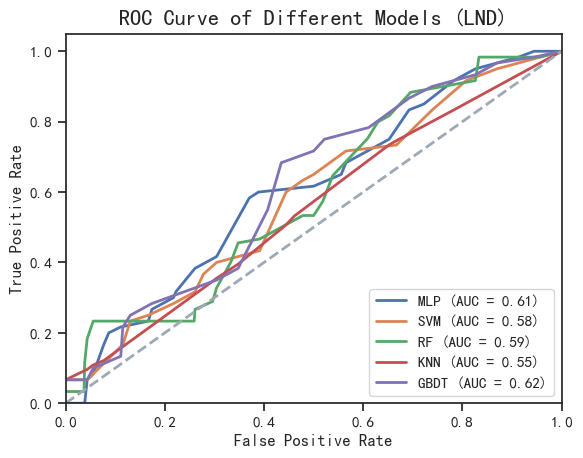

In [95]:
draw_roc(w_fpr, w_tpr, w_auc)   # with

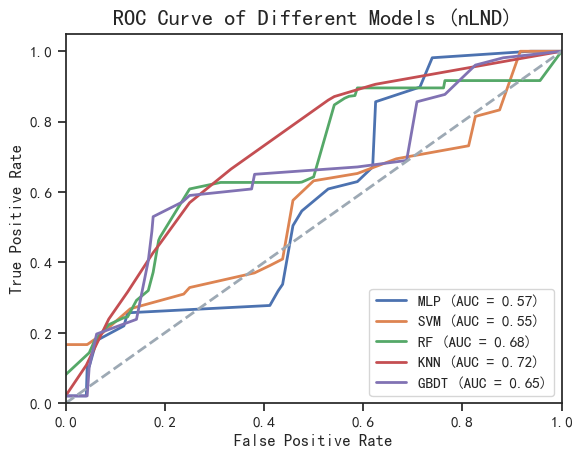

In [96]:
draw_roc(wo_fpr, wo_tpr, wo_auc, switch=False)  # without

## Discrimination and Calibration

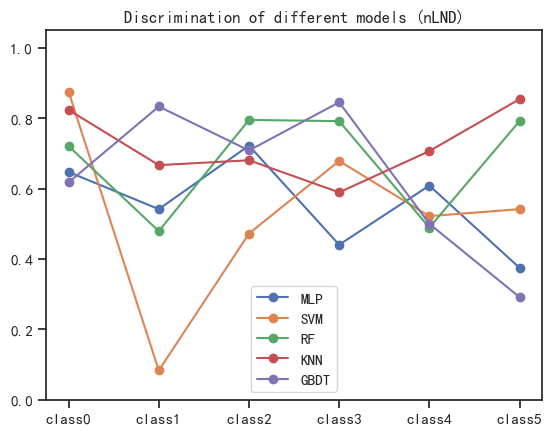

In [111]:
plt.figure()
# w_cindex
# plt.plot(w_cindex["MLP"].values(), "o-", label="MLP")
# plt.plot(w_cindex["SVM"].values(), "o-", label="SVM")
# plt.plot(w_cindex["RF"].values(), "o-", label="RF")
# plt.plot(w_cindex["KNN"].values(), "o-", label="KNN")
# plt.plot(w_cindex["GBDT"].values(), "o-", label="GBDT")
# plt.title("Discrimination of different models (LND)")
# xlabel = ["class0", "class1", "class2", "class3", "class4", "class5"]
# plt.xticks(range(0, 6), xlabel)
# plt.ylim([0.0, 1.05])
# plt.legend()
# plt.savefig('./imgs/discrimination-LND.svg')

# wo_cindex
plt.plot(wo_cindex["MLP"].values(), "o-", label="MLP")
plt.plot(wo_cindex["SVM"].values(), "o-", label="SVM")
plt.plot(wo_cindex["RF"].values(), "o-", label="RF")
plt.plot(wo_cindex["KNN"].values(), "o-", label="KNN")
plt.plot(wo_cindex["GBDT"].values(), "o-", label="GBDT")
plt.title("Discrimination of different models (nLND)")
xlabel = ["class0", "class1", "class2", "class3", "class4", "class5"]
plt.xticks(range(0, 6), xlabel)
plt.ylim([0.0, 1.05])
plt.legend()
# plt.savefig('./imgs/discrimination-nLND.svg')

plt.show()

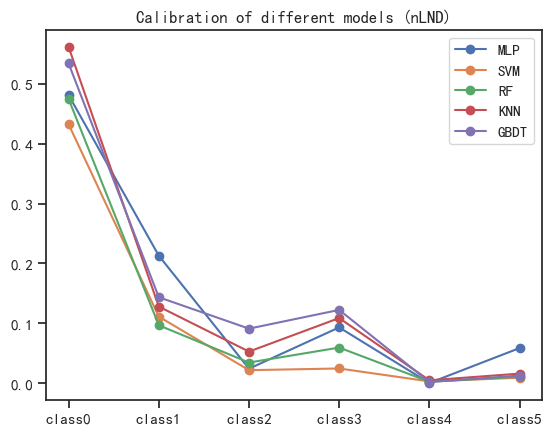

In [112]:
# w_bs
# plt.plot(w_bs["MLP"], "o-", label="MLP")
# plt.plot(w_bs["SVM"], "o-", label="SVM")
# plt.plot(w_bs["RF"], "o-", label="RF")
# plt.plot(w_bs["KNN"], "o-", label="KNN")
# plt.plot(w_bs["GBDT"], "o-", label="GBDT")
# plt.title("Calibration of different models (LND)")
# xlabel = ["class0", "class1", "class2", "class3", "class4", "class5"]
# plt.xticks(range(0, 6), xlabel)
# plt.legend()
# plt.savefig('./imgs/calibration-LND.svg')

# wo_bs
plt.plot(wo_bs["MLP"], "o-", label="MLP")
plt.plot(wo_bs["SVM"], "o-", label="SVM")
plt.plot(wo_bs["RF"], "o-", label="RF")
plt.plot(wo_bs["KNN"], "o-", label="KNN")
plt.plot(wo_bs["GBDT"], "o-", label="GBDT")
plt.title("Calibration of different models (nLND)")
xlabel = ["class0", "class1", "class2", "class3", "class4", "class5"]
plt.xticks(range(0, 6), xlabel)
plt.legend()
# plt.savefig('./imgs/calibration-nLND.svg')

plt.show()

# SHAP

使用清扫组数据进行机器学习模型可解释性探索

In [114]:
import shap
shap.initjs()
ftr_names = with_.columns[1:]

X = with_.iloc[:, 1:]
explainer = shap.TreeExplainer(clf['GBDT'][0])
# X = without_.iloc[:, 1:]
# explainer = shap.TreeExplainer(clf['GBDT'][1])

shap_values = explainer.shap_values(X)

6类  
244个训练样本  
23项特征

In [ ]:
# print(len(shap_values))
# print(shap_values[0].shape)

概括图，该图是对全部样本全部特征的shap值进行求和，可以反映出特征重要性及每个特征对样本类别预测的贡献。
- 对每个特征的SHAP值取绝对值平均，得到特征重要性分布

**对LND组模型进行特征重要性排序：**

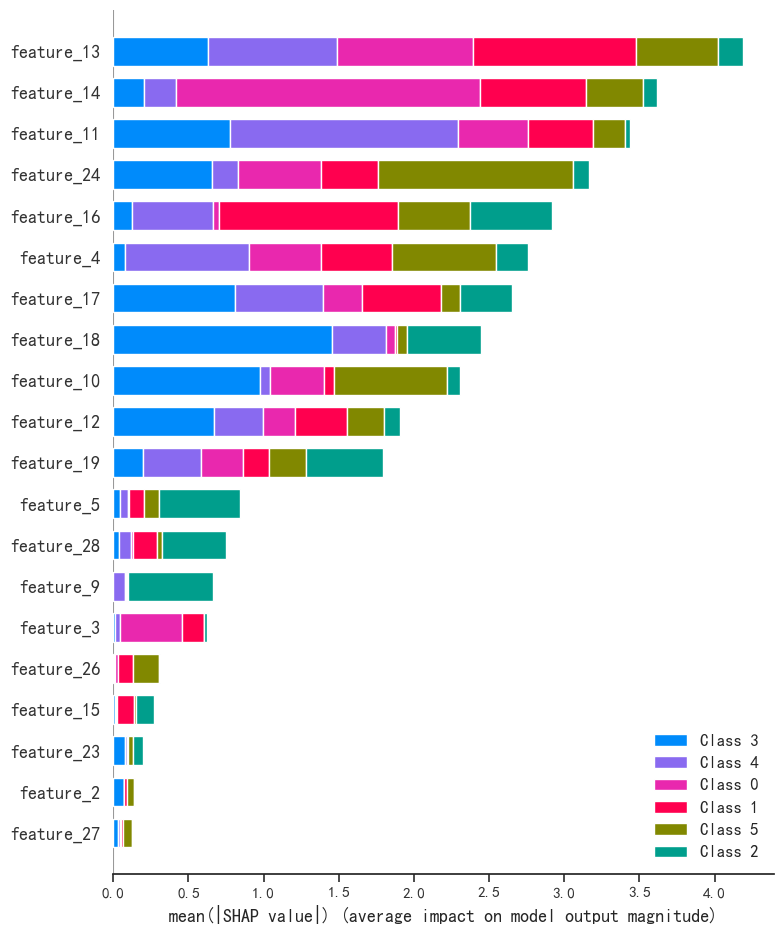

In [115]:
shap.summary_plot(shap_values, X, show=False)
# # plt.savefig('./imgs/ftr_importance-LND.svg')
# # plt.savefig('./imgs/ftr_importance-nLND.svg')